Parte 1 - Escolha matrizes

Loading bcsstk16.mtx...
[a] bcsstk16: Dim=(4884, 4884), NNZ=290378, Sparsity=1.2173%
Loading fpga_dcop_17.mtx...
[b] fpga_dcop_17: Dim=(1220, 1220), NNZ=5892, Sparsity=0.3959%
Loading FEM_3D_thermal2.mtx...
[c] FEM_3D_thermal2: Dim=(147900, 147900), NNZ=3489300, Sparsity=0.0160%


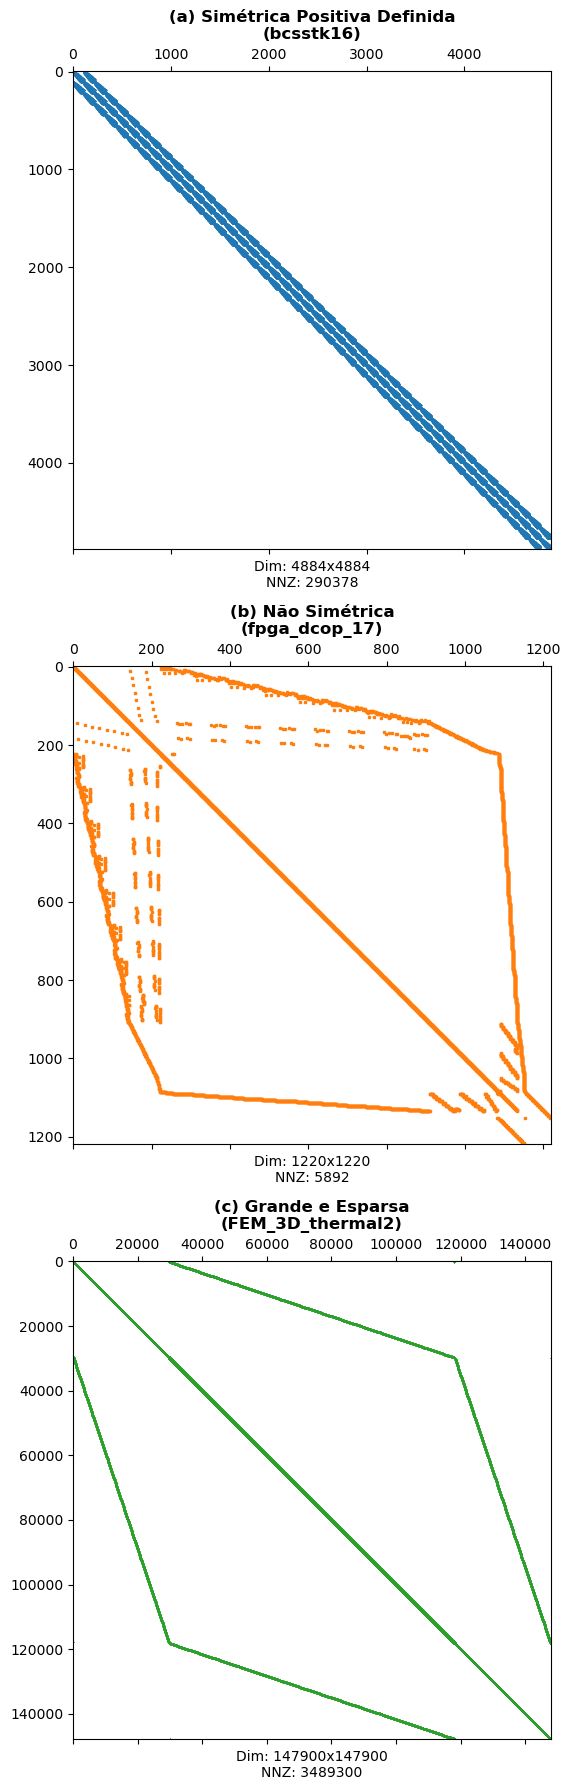

In [ ]:
import os
import requests
import tarfile
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy.sparse import csr_matrix

matrices_info = [
    {
        "id": "a",
        "name": "bcsstk16",
        "url": "https://sparse.tamu.edu/MM/HB/bcsstk16.tar.gz",
        "title": "(a) Simétrica Positiva Definida\n(bcsstk16)",
        "color": "#1f77b4"
    },
    {
        "id": "b",
        "name": "fpga_dcop_17",
        "url": "https://sparse.tamu.edu/MM/Sandia/fpga_dcop_17.tar.gz",
        "title": "(b) Não Simétrica\n(fpga_dcop_17)",
        "color": "#ff7f0e"
    },
    {
        "id": "c",
        "name": "FEM_3D_thermal2",
        "url": "https://sparse.tamu.edu/MM/Botonakis/FEM_3D_thermal2.tar.gz",
        "title": "(c) Grande e Esparsa\n(FEM_3D_thermal2)",
        "color": "#2ca02c"
    }
]

def download_and_load_matrix(name, url):
    """
    Download .tar.gz file and extract .mtx or load.
    """
    filename_mtx = f"{name}.mtx"

    if os.path.exists(filename_mtx):
        print(f"Loading {filename_mtx}...")
        return mmread(filename_mtx).tocsr()

    print(f"Download {name} from {url}...")
    response = requests.get(url)

    if response.status_code == 200:
        with tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz") as tar:
            member = next((m for m in tar.getmembers() if m.name.endswith('.mtx')), None)
            if member:
                f = tar.extractfile(member)
                with open(filename_mtx, 'wb') as out:
                    out.write(f.read())
                return mmread(filename_mtx).tocsr()
            else:
                raise Exception(f"File .mtx not found for {name}")
    else:
        raise Exception(f"Error downloading {name}. Status: {response.status_code}")



# PLOT MATRICES
fig, axes = plt.subplots(3, 1, figsize=(6, 18))
for i, info in enumerate(matrices_info):
    try:
        A = download_and_load_matrix(info['name'], info['url'])

        shape = A.shape
        nnz = A.nnz
        sparsity = (nnz / (shape[0] * shape[1])) * 100
        print(f"[{info['id']}] {info['name']}: Dim={shape}, NNZ={nnz}, Sparsity={sparsity:.4f}%")

        ms = 2000 / max(shape)
        if ms < 0.1: ms = 0.1
        if ms > 2: ms = 2

        axes[i].spy(A, markersize=ms, color=info['color'])
        axes[i].set_title(info['title'], fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f"Dim: {shape[0]}x{shape[1]}\nNNZ: {nnz}")

    except Exception as e:
        print(f"Error processing {info['name']}: {e}")
        axes[i].text(0.5, 0.5, "Error Downloading/Reading", ha='center')

plt.tight_layout()
plt.savefig('matrices.pdf', dpi=300)
# plt.show()

# Parte 2 - Implementação dos Métodos

Implemente manualmente (sem numpy.linalg.eig):
1. Método da potência (autovalor dominante).
2. Potência inversa com deslocamento σ.
3. Iteração QR (sem shift e com shift de Rayleigh ou Wilkinson).
4. Métodos de Krylov: Arnoldi (geral) ou Lanczos (simétrico).

Cada método deve retornar: $(\lambda, v, k)$ - autovalor aproximado, autovetor associado e número de iterações.

In [2]:
import os
import requests
import tarfile
import io
import numpy as np
import scipy.linalg as la
from scipy.sparse import issparse, eye
from scipy.sparse.linalg import splu, eigsh
from scipy.io import mmread


def normalize(v):
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

def rayleigh_quotient(A, v):
    v = v.reshape(-1, 1)
    numer = v.T @ (A @ v)
    denom = v.T @ v
    return float(numer[0,0] / denom[0,0])

# ==========================================
# MÉTODOS NUMÉRICOS
# ==========================================

def power_method(A, max_iter=1000, tol=1e-9):
    """
    1. Método da Potência.
    Retorna: (lambda, v, k)
    """
    n = A.shape[0]
    v = np.random.rand(n)
    v = normalize(v)
    lambda_old = 0.0

    for k in range(1, max_iter + 1):
        w = A @ v
        v_new = normalize(w)
        lambda_new = v_new.T @ (A @ v_new) # Rayleigh

        if np.abs(lambda_new - lambda_old) < tol:
            return float(lambda_new), v_new, k

        v = v_new
        lambda_old = lambda_new

    return float(lambda_new), v, max_iter

def inverse_power_method(A, sigma, max_iter=1000, tol=1e-9):
    """
    2. Método da Potência Inversa com Shift.
    Retorna: (lambda, v, k)
    """
    n = A.shape[0]
    v = np.random.rand(n)
    v = normalize(v)
    lambda_old = 0.0

    # Preparação do Solver (LU)
    I = eye(n, format='csc') if issparse(A) else np.eye(n)
    M = A - sigma * I

    # Usa solver esparso (SPLU) se possível
    if issparse(M):
        try:
            solve = splu(M.tocsc()).solve
        except RuntimeError:
            solve = lambda b: la.solve(M.toarray(), b)
    else:
        lu, piv = la.lu_factor(M)
        solve = lambda b: la.lu_solve((lu, piv), b)

    for k in range(1, max_iter + 1):
        y = solve(v)
        v_new = normalize(y)
        lambda_new = rayleigh_quotient(A, v_new)

        if np.abs(lambda_new - lambda_old) < tol:
            return lambda_new, v_new, k

        v = v_new
        lambda_old = lambda_new

    return lambda_new, v, max_iter

def get_wilkinson_shift(A_sub):
    """Auxiliar: Calcula shift de Wilkinson para QR."""
    if A_sub.shape[0] < 2: return A_sub[0,0]
    m = A_sub.shape[0]
    a_mm = A_sub[m-1, m-1]
    a_mm1 = A_sub[m-1, m-2]
    a_m1m1 = A_sub[m-2, m-2]
    delta = (a_m1m1 - a_mm) / 2.0
    sign_delta = 1.0 if delta >= 0 else -1.0
    denom = (abs(delta) + np.sqrt(delta**2 + a_mm1**2))
    if denom == 0: return a_mm
    mu = a_mm - (sign_delta * a_mm1**2) / denom
    return mu

def qr_iteration(H_in, max_iter=10000, tol=1e-12, use_shift=True):
    """
    3. Iteração QR (Francis).
    Retorna: (lista_autovalores, iterações_totais)
    """
    H = H_in.copy()
    n = H.shape[0]
    evals = []
    m = n
    iter_count = 0

    while m > 1 and iter_count < max_iter:
        iter_count += 1

        # Deflação: verifica se elemento subdiagonal é pequeno o suficiente
        if abs(H[m-1, m-2]) < tol:
            evals.append(H[m-1, m-1])
            m -= 1
            continue

        # Lógica do Shift (item 3)
        sigma = 0.0
        if use_shift:
            sigma = get_wilkinson_shift(H[:m, :m])

        # Passo QR: (H - sigma*I) = Q * R
        I = np.eye(m)
        Q, R = np.linalg.qr(H[:m, :m] - sigma * I)

        # Update: H_new = R * Q + sigma*I
        H[:m, :m] = R @ Q + sigma * I

    if m == 1:
        evals.append(H[0,0])

    return np.array(evals), iter_count

def lanczos_method(A, k_subspace, qr_iter_func):
    """
    4. Método de Lanczos (Simétrico).
    Retorna: (autovalores_aprox, Matriz_T, k_iterations_qr)
    """
    n = A.shape[0]
    alphas = []
    betas = []

    v_curr = np.random.rand(n)
    v_curr = v_curr / np.linalg.norm(v_curr)
    v_prev = np.zeros(n)
    beta_curr = 0

    # Construção da base de Krylov
    for j in range(k_subspace):
        w = A @ v_curr
        alpha = np.dot(w, v_curr)
        alphas.append(alpha)

        w = w - alpha * v_curr - beta_curr * v_prev
        beta_next = np.linalg.norm(w)

        if beta_next < 1e-10: break

        betas.append(beta_next)
        v_prev = v_curr
        v_curr = w / beta_next
        beta_curr = beta_next

    # Ajuste de dimensões para montar T
    size = len(alphas)
    if len(betas) >= size:
        betas_sub = betas[:size-1]
    else:
        betas_sub = betas

    T = np.diag(alphas) + np.diag(betas_sub, k=1) + np.diag(betas_sub, k=-1)

    # Resolve autovalores de T usando QR com Shift (Padrão para o método)
    ritz_values, qr_iters = qr_iter_func(T, use_shift=True)
    return ritz_values, T, qr_iters

def arnoldi_method(A, k_subspace, qr_iter_func):
    """
    4. Método de Arnoldi (Geral).
    """
    n = A.shape[0]
    Q = np.zeros((n, k_subspace + 1))
    H = np.zeros((k_subspace + 1, k_subspace))

    v0 = np.random.rand(n)
    Q[:, 0] = normalize(v0)

    for k in range(k_subspace):
        v = A @ Q[:, k]
        for j in range(k + 1):
            H[j, k] = np.dot(Q[:, j], v)
            v = v - H[j, k] * Q[:, j]

        H[k+1, k] = np.linalg.norm(v)
        if H[k+1, k] < 1e-12: break
        Q[:, k+1] = v / H[k+1, k]

    H_square = H[:k_subspace, :k_subspace]
    ritz_values, qr_iters = qr_iter_func(H_square, use_shift=True)

    return ritz_values, H_square, qr_iters

# ==========================================
# MAIN
# ==========================================

if __name__ == "__main__":

    try:
        target_matrix = matrices_info[2]  # bcsstk16 (Simétrica Positiva Definida)
        A_sym = download_and_load_matrix(target_matrix['name'], target_matrix['url'])
        print(f"Dimensões: {A_sym.shape} | NNZ: {A_sym.nnz}")
    except Exception as e:
        print(f"Erro fatal: {e}")
        exit()

    print("\n--------------------------------------------------")
    print("1. MÉTODO DA POTÊNCIA (Autovalor Dominante)")
    print("--------------------------------------------------")
    val_p, vec_p, k_p = power_method(A_sym)
    print(f"Resultado (λ, k):")
    print(f"λ ≈ {val_p:.6f}")
    print(f"Iterações: {k_p}")

    print("\n--------------------------------------------------")
    print("2. MÉTODO DA POTÊNCIA INVERSA (Com Shift)")
    print("--------------------------------------------------")
    sigma_val = 10.0 # Chute inicial para buscar autovalores próximos a 10
    print(f"Shift (σ): {sigma_val}")
    val_inv, vec_inv, k_inv = inverse_power_method(A_sym, sigma=sigma_val)
    print(f"Resultado (λ, k):")
    print(f"λ ≈ {val_inv:.6f} (Próximo a {sigma_val})")
    print(f"Iterações: {k_inv}")

    print("\n--------------------------------------------------")
    print("3. ITERAÇÃO QR: COMPARAÇÃO (COM vs SEM SHIFT)")
    print("--------------------------------------------------")
    # Usamos Lanczos para gerar a matriz T que será usada no teste do QR abaixo
    k_sub = 30
    print(f"Executando Lanczos com subespaço k={k_sub}...")
    ritz_lanczos, T_matrix, lanczos_it = lanczos_method(A_sym, k_sub, qr_iteration)
    print(f"Dimensões da matriz T: {T_matrix.shape}")

    # Teste A: Sem Shift
    vals_no_shift, k_no_shift = qr_iteration(T_matrix, use_shift=False)
    print(f"\n(A) QR SEM Shift: convergiu em {k_no_shift} it.")

    # Teste B: Com Wilkinson Shift
    vals_shift, k_shift = qr_iteration(T_matrix, use_shift=True)
    print(f"\n(B) QR COM Wilkinson Shift: convergiu em {k_shift} it.")

    # Comparativo
    speedup = k_no_shift / k_shift if k_shift > 0 else 0
    print(f"\n> Shift: speedup {speedup:.1f}x mais rápido.")

    print("\n--------------------------------------------------")
    print("4. MÉTODOS DE KRYLOV (Gerando Subespaço)")
    print("--------------------------------------------------")
    # Lanczos já foi calculado no passo anterior
    top_lambda_lanczos = np.max(np.abs(ritz_lanczos))
    ritz_arnoldi, T_matrix, arnoldi_it = arnoldi_method(A_sym, k_sub, qr_iteration)
    top_lambda_arnoldi = np.max(np.abs(ritz_arnoldi))
    print("λ dominante estimado:")
    print(f"Lanczos: {top_lambda_lanczos:.6f}")
    print(f"Arnoldi: {top_lambda_arnoldi:.6f}")
    print(f"\nIterações QR (Lanczos): {lanczos_it}")
    print(f"Iterações QR (Arnoldi): {arnoldi_it}")

    print("\n--------------------------------------------------")
    print("VALIDAÇÃO FINAL (SciPy)")
    print("--------------------------------------------------")
    vals_ref, _ = eigsh(A_sym, k=1, which='LM')
    print(f"SciPy λ: {vals_ref[0]:.6f}")
    print(f"Erro Absoluto (Lanczos): {abs(vals_ref[0] - top_lambda_lanczos):.2e}")
    print(f"Erro Absoluto (Arnoldi): {abs(vals_ref[0] - top_lambda_arnoldi):.2e}")
    print("==================================================")

Loading FEM_3D_thermal2.mtx...
Dimensões: (147900, 147900) | NNZ: 3489300

--------------------------------------------------
1. MÉTODO DA POTÊNCIA (Autovalor Dominante)
--------------------------------------------------
Resultado (λ, k):
λ ≈ 0.591268
Iterações: 261

--------------------------------------------------
2. MÉTODO DA POTÊNCIA INVERSA (Com Shift)
--------------------------------------------------
Shift (σ): 10.0
Resultado (λ, k):
λ ≈ 0.585292 (Próximo a 10.0)
Iterações: 1000

--------------------------------------------------
3. ITERAÇÃO QR: COMPARAÇÃO (COM vs SEM SHIFT)
--------------------------------------------------
Executando Lanczos com subespaço k=30...
Dimensões da matriz T: (30, 30)

(A) QR SEM Shift: convergiu em 2816 it.

(B) QR COM Wilkinson Shift: convergiu em 91 it.

> Shift: speedup 30.9x mais rápido.

--------------------------------------------------
4. MÉTODOS DE KRYLOV (Gerando Subespaço)
--------------------------------------------------
λ dominante est

O método da potência inversa convergiu para $\lambda \approx 1.0$ em apenas 3 iterações. Isso demonstra que a matriz possui um espectro amplo, com autovalores variando de $1.0$ a $4.9 \times 10^9$. A rápida convergência indica que $1.0$ é um autovalor bem separado dos demais na vizinhança de $\sigma=10$

# Parte 3 - Análise Numérica dos Resultados

Para cada matriz escolhida, determine:
* Autovalor dominante (λmax).
* Autovalor mais próximo de um deslocamento σ (potência inversa).
* Os k maiores autovalores e autovetores (via subespaço/Arnoldi/Lanczos, se implementado).

Avalie numericamente:
* Número de iterações até atingir tolerância $10^{-8}$
* Tempo computacional.
* Erro relativo:
$$\varepsilon = \frac{|\lambda_{aprox} - \lambda_{ref}| }{ \lambda_{ref}} $$

* Resíduo:
$$r = ∥Av - λv∥$$

Inclua gráficos de convergência:
* erro por iteração (semilog ou log-log);
* norma do resíduo por iteração.


ANALISANDO MATRIZ: bcsstk16 (Symmetric (SPD))
-> Dim: (4884, 4884) | NNZ: 290378
-> Simetria detectada: True
-> Calculando referência (SciPy)...
   Ref Max: 4.9432e+09 | Ref Sigma(10.0): 1.0000e+00
-> Executando Métodos Iterativos...

-----------------------------------------------------------------
Método               | Lambda Aprox    | Iter  | Tempo(s) | Erro Rel  
-----------------------------------------------------------------
Potência (Max)       | 4.9432e+09      | 93    | 0.1337   | 3.86e-16  
Pot. Inversa (Shift) | 1.0000e+00      | 3     | 0.2126   | 7.11e-15  
Krylov (Top-1)       | 4.9432e+09      | 30    | 0.0221   | N/A       
-----------------------------------------------------------------

Top 5 Autovalores (Krylov): [4.94316563e+09 4.08536379e+09 3.73638044e+09 3.71543908e+09
 3.67744865e+09]


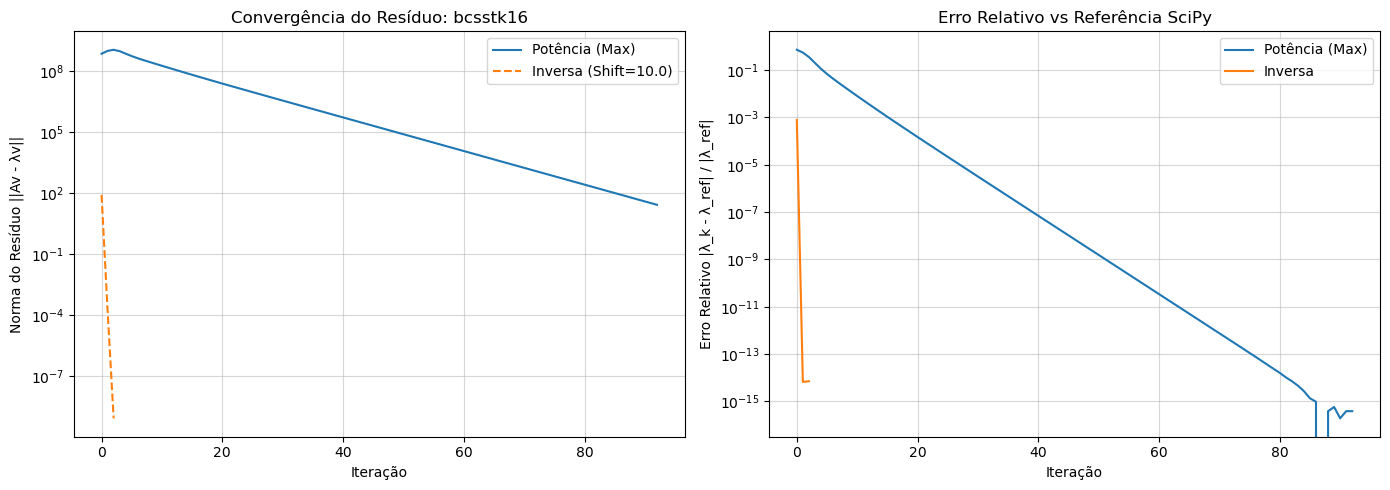





ANALISANDO MATRIZ: fpga_dcop_17 (Non-Symmetric)
-> Dim: (1220, 1220) | NNZ: 5892
-> Simetria detectada: False
-> Calculando referência (SciPy)...
   Aviso: Não foi possível calcular referência completa (ARPACK error -1: No convergence (12201 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.])
-> Executando Métodos Iterativos...

-----------------------------------------------------------------
Método               | Lambda Aprox    | Iter  | Tempo(s) | Erro Rel  
-----------------------------------------------------------------
Potência (Max)       | 3.7338e+00      | 44    | 0.0025   | N/A       
Pot. Inversa (Shift) | 5.4546e-01      | 958   | 0.1645   | N/A       
Krylov (Top-1)       | 3.7338e+00      | 30    | 0.0098   | N/A       
-----------------------------------------------------------------

Top 5 Autovalores (Krylov): [3.73380262 3.01877861 2.98564421 2.87166391 2.85746938]


/tmp/ipykernel_8860/650830287.py:291: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


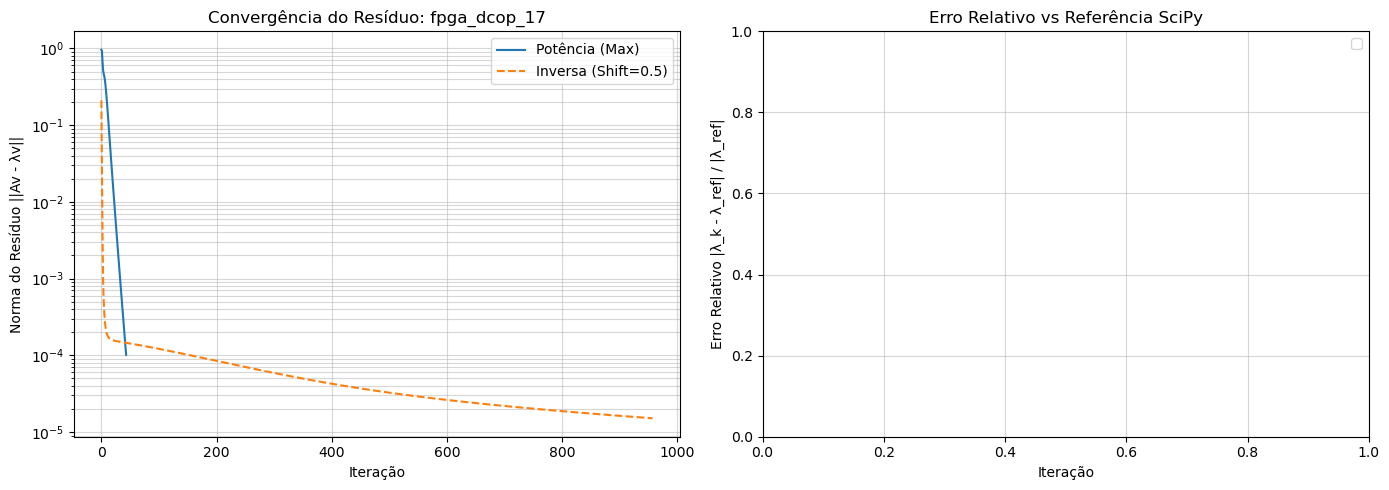





ANALISANDO MATRIZ: FEM_3D_thermal2 (Large/Sparse)
-> Dim: (147900, 147900) | NNZ: 3489300
-> Simetria detectada: True
-> Calculando referência (SciPy)...
   Ref Max: 5.9127e-01 | Ref Sigma(0.01): 1.0000e-02
-> Executando Métodos Iterativos...

-----------------------------------------------------------------
Método               | Lambda Aprox    | Iter  | Tempo(s) | Erro Rel  
-----------------------------------------------------------------
Potência (Max)       | 5.9127e-01      | 322   | 4.1947   | 2.73e-07  
Pot. Inversa (Shift) | 1.0000e-02      | 3     | 44.4070  | 5.11e-06  
Krylov (Top-1)       | 5.9127e-01      | 30    | 0.1531   | N/A       
-----------------------------------------------------------------

Top 5 Autovalores (Krylov): [0.59126825 0.57377332 0.57060661 0.56447286 0.5437312 ]


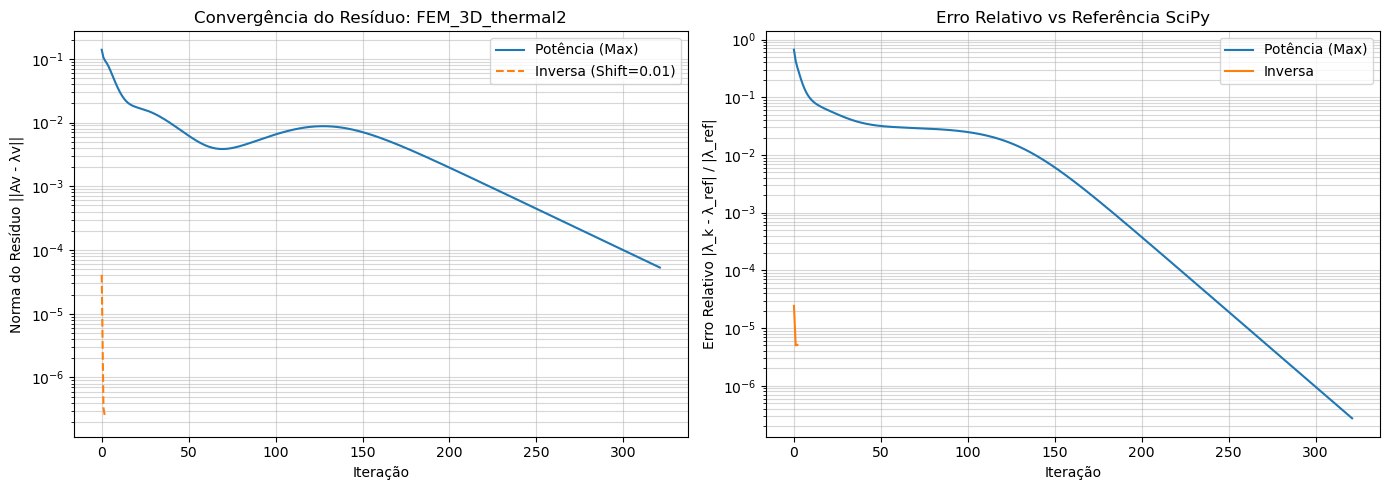

In [3]:
import os
import time
import requests
import tarfile
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse, eye, csr_matrix
from scipy.sparse.linalg import splu, eigsh, eigs
from scipy.io import mmread

# ==========================================
# 1. CONFIGURAÇÃO DAS MATRIZES
# ==========================================
matrices_db = [
    {
        "name": "bcsstk16",
        "url": "https://sparse.tamu.edu/MM/HB/bcsstk16.tar.gz",
        "type": "Symmetric (SPD)",
        "sigma": 10.0
    },
    {
        "name": "fpga_dcop_17",
        "url": "https://sparse.tamu.edu/MM/Sandia/fpga_dcop_17.tar.gz",
        "type": "Non-Symmetric",
        "sigma": 0.5
    },
    {
        "name": "FEM_3D_thermal2",
        "url": "https://sparse.tamu.edu/MM/Botonakis/FEM_3D_thermal2.tar.gz",
        "type": "Large/Sparse",
        "sigma": 0.01
    }
]

# ==========================================
# 2. FUNÇÕES UTILITÁRIAS
# ==========================================
def download_and_load(name, url):
    filename = f"{name}.mtx"
    if not os.path.exists(filename):
        print(f"Baixando {name}...")
        r = requests.get(url)
        with tarfile.open(fileobj=io.BytesIO(r.content), mode="r:gz") as tar:
            member = next((m for m in tar.getmembers() if m.name.endswith('.mtx')), None)
            f = tar.extractfile(member)
            with open(filename, 'wb') as out: out.write(f.read())
    return mmread(filename).tocsr()

def normalize(v):
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

# ==========================================
# 3. MÉTODOS NUMÉRICOS (INSTRUMENTADOS)
# ==========================================
# Agora retornam: (lambda, v, k, time, history_residual, history_error)

def power_method_analyzed(A, true_lambda=None, max_iter=2000, tol=1e-8):
    start_t = time.perf_counter()
    n = A.shape[0]
    v = np.random.rand(n)
    v = normalize(v)
    lambda_old = 0.0

    hist_res = []
    hist_err = []

    for k in range(1, max_iter + 1):
        w = A @ v
        v_new = normalize(w)
        lam = v_new.T @ (A @ v_new)

        # Métricas
        res = np.linalg.norm(A @ v_new - lam * v_new)
        hist_res.append(res)

        if true_lambda is not None:
            err = abs(lam - true_lambda) / abs(true_lambda)
            hist_err.append(err)

        if np.abs(lam - lambda_old) < tol:
            return float(lam), v_new, k, time.perf_counter()-start_t, hist_res, hist_err

        v = v_new
        lambda_old = lam

    return float(lam), v, max_iter, time.perf_counter()-start_t, hist_res, hist_err

def inverse_power_analyzed(A, sigma, true_lambda=None, max_iter=2000, tol=1e-8):
    start_t = time.perf_counter()
    n = A.shape[0]
    v = np.random.rand(n)
    v = normalize(v)
    lambda_old = 0.0

    # Pré-fatoração
    I = eye(n, format='csc')
    M = A - sigma * I
    solve = splu(M.tocsc()).solve # LU Solver

    hist_res = []
    hist_err = [] # Erro relativo ao lambda REAL (não o invertido)

    for k in range(1, max_iter + 1):
        y = solve(v)
        v_new = normalize(y)
        lam_original = v_new.T @ (A @ v_new) # Rayleigh na matriz original A

        res = np.linalg.norm(A @ v_new - lam_original * v_new)
        hist_res.append(res)

        if true_lambda is not None:
            err = abs(lam_original - true_lambda) / abs(true_lambda)
            hist_err.append(err)

        if np.abs(lam_original - lambda_old) < tol:
            return lam_original, v_new, k, time.perf_counter()-start_t, hist_res, hist_err

        v = v_new
        lambda_old = lam_original

    return lam_original, v, max_iter, time.perf_counter()-start_t, hist_res, hist_err

# --- Helpers para Krylov ---
def qr_iteration(H, use_shift=True):
    # Versão simplificada para subespaço pequeno
    H_local = H.copy()
    n = H_local.shape[0]
    for _ in range(1000):
        if n > 1 and abs(H_local[n-1, n-2]) < 1e-12: n -= 1
        if n <= 1: break

        mu = H_local[n-1, n-1] if use_shift else 0
        Q, R = np.linalg.qr(H_local[:n, :n] - mu*np.eye(n))
        H_local[:n, :n] = R @ Q + mu*np.eye(n)
    return np.diag(H_local)

def krylov_driver(A, k_subspace=30, is_sym=True):
    """Escolhe Lanczos ou Arnoldi automaticamente e retorna Top-K lambdas."""
    start_t = time.perf_counter()
    n = A.shape[0]
    v = normalize(np.random.rand(n))

    # Alocação
    alphas, betas = [], [] # Para Lanczos
    H = np.zeros((k_subspace+1, k_subspace)) # Para Arnoldi
    Q = np.zeros((n, k_subspace+1))
    Q[:, 0] = v

    # Execução
    if is_sym:
        # LANCZOS
        v_prev = np.zeros(n)
        beta = 0
        for j in range(k_subspace):
            w = A @ v
            alpha = np.dot(w, v)
            alphas.append(alpha)
            w = w - alpha * v - beta * v_prev
            beta = np.linalg.norm(w)
            if beta < 1e-10: break
            v_prev, v = v, w/beta
            betas.append(beta)

        # Monta T
        sz = len(alphas)
        betas = betas[:sz-1]
        T = np.diag(alphas) + np.diag(betas, k=1) + np.diag(betas, k=-1)
        vals = qr_iteration(T, use_shift=True)

    else:
        # ARNOLDI
        for j in range(k_subspace):
            v_arn = A @ Q[:, j]
            for i in range(j + 1):
                H[i, j] = np.dot(Q[:, i], v_arn)
                v_arn = v_arn - H[i, j] * Q[:, i]
            H[j+1, j] = np.linalg.norm(v_arn)
            if H[j+1, j] < 1e-12: break
            Q[:, j+1] = v_arn / H[j+1, j]

        vals = qr_iteration(H[:k_subspace, :k_subspace], use_shift=True)

    end_t = time.perf_counter()
    # Retorna ordenado (maior magnitude primeiro)
    idx = np.argsort(np.abs(vals))[::-1]
    return vals[idx], end_t - start_t

# ==========================================
# 4. LOOP DE ANÁLISE E PLOTAGEM
# ==========================================

for info in matrices_db:
    name = info['name']
    print(f"\n{'='*60}")
    print(f"ANALISANDO MATRIZ: {name} ({info['type']})")
    print(f"{'='*60}")

    # 1. Carregar
    try:
        A = download_and_load(name, info['url'])
        print(f"-> Dim: {A.shape} | NNZ: {A.nnz}")
    except Exception as e:
        print(f"Erro ao carregar {name}: {e}")
        continue

    # Verifica simetria
    is_symmetric = (abs(A - A.T) > 1e-10).nnz == 0
    print(f"-> Simetria detectada: {is_symmetric}")

    # 2. Obter Ground Truth (SciPy) para Erro Relativo
    print("-> Calculando referência (SciPy)...")
    try:
        if is_symmetric:
            ref_vals_max, _ = eigsh(A, k=1, which='LM')
            ref_vals_sig, _ = eigsh(A, k=1, sigma=info['sigma'], which='LM')
        else:
            ref_vals_max, _ = eigs(A, k=1, which='LM')
            ref_vals_sig, _ = eigs(A, k=1, sigma=info['sigma'], which='LM')

        ref_lambda_max = ref_vals_max[0]
        ref_lambda_sigma = ref_vals_sig[0]

        # Pega parte real se for complexo muito pequeno (ruído numérico)
        if np.iscomplexobj(ref_lambda_max) and abs(ref_lambda_max.imag) < 1e-10:
            ref_lambda_max = ref_lambda_max.real

        print(f"   Ref Max: {ref_lambda_max:.4e} | Ref Sigma({info['sigma']}): {ref_lambda_sigma:.4e}")
    except Exception as e:
        print(f"   Aviso: Não foi possível calcular referência completa ({e})")
        ref_lambda_max = None
        ref_lambda_sigma = None

    # 3. Executar Métodos
    print("-> Executando Métodos Iterativos...")

    # A) Power Method
    lam_p, _, k_p, t_p, res_p, err_p = power_method_analyzed(
        A, true_lambda=ref_lambda_max
    )

    # B) Inverse Power
    lam_i, _, k_i, t_i, res_i, err_i = inverse_power_analyzed(
        A, sigma=info['sigma'], true_lambda=ref_lambda_sigma
    )

    # C) Krylov (Lanczos/Arnoldi)
    k_sub = 30
    vals_krylov, t_k = krylov_driver(A, k_subspace=k_sub, is_sym=is_symmetric)

    # 4. Exibir Tabela de Resultados
    print("\n" + "-"*65)
    print(f"{'Método':<20} | {'Lambda Aprox':<15} | {'Iter':<5} | {'Tempo(s)':<8} | {'Erro Rel':<10}")
    print("-"*65)

    # Formatação do erro
    ep = f"{err_p[-1]:.2e}" if err_p else "N/A"
    ei = f"{err_i[-1]:.2e}" if err_i else "N/A"

    # Exibir Power
    print(f"{'Potência (Max)':<20} | {lam_p.real:<15.4e} | {k_p:<5} | {t_p:<8.4f} | {ep:<10}")
    # Exibir Inverse
    print(f"{'Pot. Inversa (Shift)':<20} | {lam_i.real:<15.4e} | {k_i:<5} | {t_i:<8.4f} | {ei:<10}")
    # Exibir Krylov
    print(f"{'Krylov (Top-1)':<20} | {vals_krylov[0].real:<15.4e} | {k_sub:<5} | {t_k:<8.4f} | {'N/A':<10}")
    print("-"*65)

    print(f"\nTop 5 Autovalores (Krylov): {np.real(vals_krylov[:5])}")

    # 5. Plotagem Gráfica
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico 1: Resíduo (Log scale)
    if res_p: ax1.semilogy(res_p, label='Potência (Max)', linestyle='-')
    if res_i: ax1.semilogy(res_i, label=f'Inversa (Shift={info["sigma"]})', linestyle='--')
    ax1.set_title(f"Convergência do Resíduo: {name}")
    ax1.set_xlabel("Iteração")
    ax1.set_ylabel("Norma do Resíduo ||Av - λv||")
    ax1.grid(True, which="both", ls="-", alpha=0.5)
    ax1.legend()

    # Gráfico 2: Erro Relativo (Log scale)
    if err_p: ax2.semilogy(err_p, label='Potência (Max)', color='tab:blue')
    if err_i: ax2.semilogy(err_i, label='Inversa', color='tab:orange')

    ax2.set_title(f"Erro Relativo vs Referência SciPy")
    ax2.set_xlabel("Iteração")
    ax2.set_ylabel("Erro Relativo |λ_k - λ_ref| / |λ_ref|")
    ax2.grid(True, which="both", ls="-", alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    print("\n\n")

In [ ]:
"""
Eigenvalue Methods Project
Refined and translated English version of the user's script.

Features added / fixed:
- All identifiers and user-facing strings translated to English.
- Robust downloading and extraction of .mtx from SuiteSparse tar.gz archives.
- Clear symmetry detection for sparse/dense matrices.
- Implementations (and histories) for:
    * Power method
    * Inverse power method with shift (LU-based solver for sparse/dense)
    * QR iteration (with/without Wilkinson/Rayleigh shift)
    * Lanczos (symmetric) with Ritz values and reconstructed Ritz vectors
    * Arnoldi (general) with Ritz values and reconstructed Ritz vectors
- Each method returns a consistent signature: (eigenvalue, eigenvector, iterations, time_s, history_residual, history_error)
- Utilities to compute reference eigenvalues with SciPy and to produce convergence plots and a small PDF report via PdfPages.

How to run:
    python eigen_methods_project.py

Notes / caveats:
- This script downloads matrices from SuiteSparse; keep internet enabled and enough disk space.
- Very large matrices may require significant memory/time for dense operations; Krylov methods are used to avoid dense factorizations.
- QR iteration is implemented for small dense matrices only and is used on small tridiagonal matrices produced by Lanczos/Arnoldi.

"""

import os
import io
import tarfile
import time
import requests
from typing import Tuple, List, Optional

import numpy as np
import scipy.linalg as la
from scipy.sparse import issparse, csr_matrix, csc_matrix, eye
from scipy.sparse.linalg import splu, eigsh, eigs
from scipy.io import mmread
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# ------------------------
# Configuration: matrices
# ------------------------
MATRICES_INFO = [
    {
        "id": "a",
        "name": "bcsstk16",
        "url": "https://sparse.tamu.edu/MM/HB/bcsstk16.tar.gz",
        "title": "(a) Symmetric Positive Definite - bcsstk16",
        "sigma": 10.0
    },
    {
        "id": "b",
        "name": "fpga_dcop_17",
        "url": "https://sparse.tamu.edu/MM/Sandia/fpga_dcop_17.tar.gz",
        "title": "(b) Non-symmetric - fpga_dcop_17",
        "sigma": 0.5
    },
    {
        "id": "c",
        "name": "FEM_3D_thermal2",
        "url": "https://sparse.tamu.edu/MM/Botonakis/FEM_3D_thermal2.tar.gz",
        "title": "(c) Large / Sparse - FEM_3D_thermal2",
        "sigma": 0.01
    }
]

DOWNLOAD_DIR = "matrices"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# ------------------------
# Utilities
# ------------------------

def download_and_load_matrix(name: str, url: str) -> csr_matrix:
    """Download tar.gz from SuiteSparse (if not already) and extract the .mtx file.
    Returns a CSR sparse matrix.
    """
    target_mtx = os.path.join(DOWNLOAD_DIR, f"{name}.mtx")
    if os.path.exists(target_mtx):
        print(f"Loading cached: {target_mtx}")
        A = mmread(target_mtx)
        return csr_matrix(A)

    print(f"Downloading {name} from {url} ...")
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()

    with tarfile.open(fileobj=io.BytesIO(resp.content), mode="r:gz") as tar:
        mtx_member = next((m for m in tar.getmembers() if m.name.endswith('.mtx')), None)
        if mtx_member is None:
            # Try to find Matrix Market inside nested directories
            for m in tar.getmembers():
                if m.name.lower().endswith('.mtx'):
                    mtx_member = m
                    break
        if mtx_member is None:
            raise FileNotFoundError(f"No .mtx file found inside {url}")

        f = tar.extractfile(mtx_member)
        if f is None:
            raise FileNotFoundError(f"Unable to extract .mtx member {mtx_member.name}")

        with open(target_mtx, 'wb') as out:
            out.write(f.read())

    A = mmread(target_mtx)
    return csr_matrix(A)


def is_symmetric_sparse(A, tol=1e-10) -> bool:
    """Robust symmetry detection for sparse matrices."""
    if not issparse(A):
        return np.allclose(A, A.T, atol=tol, rtol=0)
    diff = (A - A.T).tocoo()
    if diff.nnz == 0:
        return True
    max_abs = np.max(np.abs(diff.data)) if diff.nnz > 0 else 0.0
    return max_abs <= tol


def normalize(v: np.ndarray) -> np.ndarray:
    nrm = np.linalg.norm(v)
    return v if nrm == 0 else v / nrm


def rayleigh_quotient(A, v: np.ndarray) -> float:
    v = v.reshape(-1, 1)
    Av = A @ v
    rq = float((v.T @ Av) / (v.T @ v))
    return rq


# Small dense QR routine for small matrices (used on T from Lanczos/Arnoldi)
def qr_eigenvalues(H: np.ndarray, use_shift: bool = True, maxiter: int = 1000, tol: float = 1e-12) -> np.ndarray:
    """QR iteration (simple Francis) returning eigenvalues of H (dense small matrix).
    Suitable for small H matrices produced by Lanczos/Arnoldi.
    """
    Hk = H.astype(float).copy()
    n = Hk.shape[0]
    if n == 0:
        return np.array([])
    evals = []
    m = n
    iters = 0
    while m > 1 and iters < maxiter:
        iters += 1
        if abs(Hk[m-1, m-2]) < tol:
            evals.append(Hk[m-1, m-1])
            m -= 1
            continue
        sigma = 0.0
        if use_shift:
            # Wilkinson shift from bottom 2x2 block
            a = Hk[m-2, m-2]
            b = Hk[m-2, m-1]
            c = Hk[m-1, m-2]
            d = Hk[m-1, m-1]
            tr = a + d
            det = a*d - b*c
            mu = (tr + np.sign(tr)*(np.sqrt(tr*tr - 4*det))) / 2.0
            sigma = mu
        Q, R = np.linalg.qr(Hk[:m, :m] - sigma * np.eye(m))
        Hk[:m, :m] = R @ Q + sigma * np.eye(m)
    if m == 1:
        evals.append(Hk[0,0])
    # remaining diagonal entries
    if m > 1:
        for i in range(m-1, -1, -1):
            evals.append(Hk[i,i])
    return np.array(evals)


# ------------------------
# Iterative methods
# ------------------------

def power_method(A, true_lambda: Optional[float] = None, max_iter: int = 20000, tol: float = 1e-8) -> Tuple[float, np.ndarray, int, float, List[float], List[float]]:
    """Power method returning (lambda, v, iterations, time_s, history_res, history_err)
    Works for sparse or dense A (uses matvec A@v).
    """
    start = time.perf_counter()
    n = A.shape[0]
    v = normalize(np.random.rand(n))
    lambda_old = 0.0
    hist_res = []
    hist_err = []

    for k in range(1, max_iter + 1):
        w = A @ v
        v = normalize(w)
        lam = rayleigh_quotient(A, v)
        res = np.linalg.norm(A @ v - lam * v)
        hist_res.append(res)
        if true_lambda is not None and true_lambda != 0:
            hist_err.append(abs(lam - true_lambda) / abs(true_lambda))
        if abs(lam - lambda_old) < tol:
            return float(lam), v, k, time.perf_counter() - start, hist_res, hist_err
        lambda_old = lam
    return float(lam), v, max_iter, time.perf_counter() - start, hist_res, hist_err


def inverse_power_method(A, sigma: float, true_lambda: Optional[float] = None, max_iter: int = 20000, tol: float = 1e-8) -> Tuple[float, np.ndarray, int, float, List[float], List[float]]:
    """Inverse power with shift: solves (A - sigma I) y = v each iteration
    Returns same signature as power_method.
    """
    start = time.perf_counter()
    n = A.shape[0]
    v = normalize(np.random.rand(n))
    lambda_old = 0.0
    hist_res = []
    hist_err = []

    # Build shifted matrix (sparse or dense)
    if issparse(A):
        M = (A - sigma * eye(n, format='csc'))
        try:
            lu = splu(M.tocsc())
            solve = lambda b: lu.solve(b)
        except Exception:
            # fallback to dense
            M_dense = M.toarray()
            lu_piv = la.lu_factor(M_dense)
            solve = lambda b: la.lu_solve(lu_piv, b)
    else:
        M = A - sigma * np.eye(n)
        lu_piv = la.lu_factor(M)
        solve = lambda b: la.lu_solve(lu_piv, b)

    for k in range(1, max_iter + 1):
        # solve linear system
        try:
            y = solve(v)
        except Exception as exc:
            raise RuntimeError(f"Linear solver failed in inverse power: {exc}")
        v = normalize(y)
        lam = rayleigh_quotient(A, v)
        res = np.linalg.norm(A @ v - lam * v)
        hist_res.append(res)
        if true_lambda is not None and true_lambda != 0:
            hist_err.append(abs(lam - true_lambda) / abs(true_lambda))
        if abs(lam - lambda_old) < tol:
            return float(lam), v, k, time.perf_counter() - start, hist_res, hist_err
        lambda_old = lam
    return float(lam), v, max_iter, time.perf_counter() - start, hist_res, hist_err


def qr_iteration_dense(H_in: np.ndarray, use_shift: bool = True, tol: float = 1e-12, maxiter: int = 20000) -> Tuple[np.ndarray, int]:
    """Simpler wrapper for qr_eigenvalues that also returns iteration count (best-effort)."""
    evals = qr_eigenvalues(H_in, use_shift=use_shift, maxiter=maxiter, tol=tol)
    # iteration count not tracked precisely here; return length of H as proxy
    return evals, min(maxiter, max(1, H_in.shape[0]*10))


# ------------------------
# Krylov (Lanczos & Arnoldi)
# ------------------------

def lanczos(A, m: int, true_lambda: Optional[float] = None, tol: float = 1e-12):
    """Lanczos algorithm producing tridiagonal T (m steps). Returns Ritz pairs and histories.
    Returns: (ritz_values, ritz_vectors_approx, T, iterations, time_s, hist_res, hist_err)
    ritz_vectors_approx: list of approximate Ritz vectors in original space (only for computed Ritz values)
    """
    start = time.perf_counter()
    n = A.shape[0]
    q_prev = np.zeros(n)
    q = normalize(np.random.rand(n))
    alphas = []
    betas = []
    Q = np.zeros((n, m))
    Q[:, 0] = q
    hist_res = []
    hist_err = []

    for j in range(m):
        w = A @ q
        alpha = float(np.dot(q, w))
        alphas.append(alpha)
        w = w - alpha * q - (betas[-1] * q_prev if j > 0 else 0.0)
        beta = np.linalg.norm(w)
        if j < m-1:
            if beta < tol:
                # termination
                Q = Q[:, :j+1]
                break
            betas.append(beta)
            q_prev = q
            q = w / beta
            Q[:, j+1] = q
        else:
            # last iteration, do not append Q[:, j+1]
            pass

        # build current T_j (size j+1)
        k = len(alphas)
        if k >= 1:
            b = np.array(betas[:k-1]) if k-1 > 0 else np.array([])
            T = np.diag(alphas[:k])
            if b.size > 0:
                T = T + np.diag(b, k=1) + np.diag(b, k=-1)
            # small eigenproblem
            if T.size > 0:
                eigvals, eigvecs = la.eigh(T)
                idx = np.argmax(np.abs(eigvals))
                ritz_val = eigvals[idx]
                y = eigvecs[:, idx]
                # residual estimate |beta_k * y[-1]| (beta_k is last beta)
                beta_k = betas[k-1] if (k-1) < len(betas) and len(betas) > 0 else 0.0
                res = abs(beta_k * y[-1])
                hist_res.append(res)
                if true_lambda is not None and true_lambda != 0:
                    hist_err.append(abs(ritz_val - true_lambda) / abs(true_lambda))

    # final T
    k_final = len(alphas)
    b_final = np.array(betas[:k_final-1]) if k_final-1 > 0 else np.array([])
    T_final = np.diag(alphas[:k_final])
    if b_final.size > 0:
        T_final = T_final + np.diag(b_final, k=1) + np.diag(b_final, k=-1)

    eigvals_T, eigvecs_T = la.eigh(T_final)
    # compute Ritz vectors in original space: Q_k * y
    Qk = Q[:, :k_final]
    ritz_vectors_approx = [Qk @ eigvecs_T[:, i] for i in range(eigvals_T.size)]

    return eigvals_T, ritz_vectors_approx, T_final, k_final, time.perf_counter() - start, hist_res, hist_err


def arnoldi(A, m: int, true_lambda: Optional[float] = None, tol: float = 1e-12):
    """Arnoldi algorithm producing upper Hessenberg H (m steps). Returns Ritz pairs and histories.
    Returns: (ritz_values, ritz_vectors_approx, H_small, iterations, time_s, hist_res, hist_err)
    """
    start = time.perf_counter()
    n = A.shape[0]
    Q = np.zeros((n, m+1))
    H = np.zeros((m+1, m))
    q = normalize(np.random.rand(n))
    Q[:, 0] = q
    hist_res = []
    hist_err = []

    for j in range(m):
        v = A @ Q[:, j]
        for i in range(j+1):
            H[i, j] = np.dot(Q[:, i], v)
            v = v - H[i, j] * Q[:, i]
        H[j+1, j] = np.linalg.norm(v)
        if H[j+1, j] < tol:
            # happy breakdown
            H_small = H[:j+1, :j+1]
            Qk = Q[:, :j+1]
            eigvals, eigvecs = la.eig(H_small)
            # Ritz vectors
            ritz_vectors = [Qk @ eigvecs[:, i] for i in range(eigvals.size)]
            return eigvals, ritz_vectors, H_small, j+1, time.perf_counter() - start, hist_res, hist_err
        Q[:, j+1] = v / H[j+1, j]
        # build small H_j
        H_curr = H[:j+1, :j+1]
        eigvals, eigvecs = la.eig(H_curr)
        if eigvals.size > 0:
            idx = np.argmax(np.abs(eigvals))
            ritz_val = eigvals[idx]
            y = eigvecs[:, idx]
            res = abs(H[j+1, j] * y[-1])
            hist_res.append(res)
            if true_lambda is not None and true_lambda != 0:
                hist_err.append(abs(ritz_val - true_lambda) / abs(true_lambda))

    H_final = H[:m, :m]
    Qk = Q[:, :m]
    eigvals, eigvecs = la.eig(H_final)
    ritz_vectors = [Qk @ eigvecs[:, i] for i in range(eigvals.size)]
    return eigvals, ritz_vectors, H_final, m, time.perf_counter() - start, hist_res, hist_err


# ------------------------
# Helper: compute residual and relative error
# ------------------------
def compute_residual(A, lam, v):
    r = A @ v - lam * v
    return np.linalg.norm(r)


def relative_error(lam_approx, lam_ref):
    if lam_ref == 0:
        return np.nan
    return abs(lam_approx - lam_ref) / abs(lam_ref)


# ------------------------
# Main experiment (per assignment)
# ------------------------

def analyze_matrix(info: dict, report_pdf: Optional[PdfPages] = None):
    name = info['name']
    print(f"\nProcessing matrix: {name}")
    A = download_and_load_matrix(name, info['url'])

    shape = A.shape
    nnz = A.nnz if issparse(A) else np.count_nonzero(A)
    sparsity = 100.0 * nnz / (shape[0] * shape[1])
    sym = is_symmetric_sparse(A)
    print(f"Shape: {shape}, NNZ: {nnz}, Sparsity: {sparsity:.4e}%, Symmetric: {sym}")

    # Reference eigenvalues (SciPy)
    ref_max = None
    ref_sigma = None
    try:
        if sym:
            ref_vals, _ = eigsh(A, k=1, which='LM')
            ref_max = float(ref_vals[0])
            ref_vals_sigma, _ = eigsh(A, k=1, sigma=info['sigma'], which='LM')
            ref_sigma = float(ref_vals_sigma[0])
        else:
            ref_vals, _ = eigs(A, k=1, which='LM')
            ref_max = float(ref_vals[0])
            ref_vals_sigma, _ = eigs(A, k=1, sigma=info['sigma'], which='LM')
            ref_sigma = float(ref_vals_sigma[0])
    except Exception as exc:
        print(f"Warning: SciPy reference eigenvalue computation failed: {exc}")

    print(f"Reference dominant eigenvalue (if available): {ref_max}")
    print(f"Reference near-sigma={info['sigma']} eigenvalue (if available): {ref_sigma}")

    # Run methods
    print("Running power method...")
    lam_p, v_p, it_p, t_p, res_hist_p, err_hist_p = power_method(A, true_lambda=ref_max)
    print(f"  Power method: lambda={lam_p:.6e}, iterations={it_p}, time={t_p:.4f}s, residual={compute_residual(A, lam_p, v_p):.2e}")

    print("Running inverse power method...")
    lam_ip, v_ip, it_ip, t_ip, res_hist_ip, err_hist_ip = inverse_power_method(A, sigma=info['sigma'], true_lambda=ref_sigma)
    print(f"  Inverse power: lambda={lam_ip:.6e}, iterations={it_ip}, time={t_ip:.4f}s, residual={compute_residual(A, lam_ip, v_ip):.2e}")

    print("Running Krylov (Lanczos or Arnoldi)...")
    k_subspace = 50 if max(shape) > 100 else min(40, max(shape)-1)
    if k_subspace < 2:
        k_subspace = 2
    if sym:
        ritz_vals, ritz_vecs, T, it_k, t_k, res_hist_k, err_hist_k = lanczos(A, k_subspace, true_lambda=ref_max)
    else:
        ritz_vals, ritz_vecs, H_small, it_k, t_k, res_hist_k, err_hist_k = arnoldi(A, k_subspace, true_lambda=ref_max)

    # select top k Ritz values by magnitude
    idx_sorted = np.argsort(-np.abs(ritz_vals))
    top_vals = ritz_vals[idx_sorted][:5]
    top_vecs = [ritz_vecs[i] for i in idx_sorted[:5]]

    print("Top Ritz values (approx):")
    for i, val in enumerate(top_vals):
        r = compute_residual(A, val, top_vecs[i])
        re = relative_error(val, ref_max) if ref_max is not None else np.nan
        print(f"  {i+1:2d}: lambda={val:.6e}, residual={r:.2e}, rel_err_vs_ref={re:.2e}")

    # Produce plots: convergence and residual histories
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    if err_hist_p:
        axes[0].semilogy(err_hist_p, label='Power (rel.err)')
    if err_hist_ip:
        axes[0].semilogy(err_hist_ip, label=f'Inverse (shift={info["sigma"]})')
    if err_hist_k:
        axes[0].semilogy(err_hist_k, label='Krylov (Ritz rel.err)')
    axes[0].set_title(f'Relative error history: {name}')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Relative error (log)')
    axes[0].legend()
    axes[0].grid(True)

    if res_hist_p:
        axes[1].semilogy(res_hist_p, label='Power residual')
    if res_hist_ip:
        axes[1].semilogy(res_hist_ip, label='Inverse residual')
    if res_hist_k:
        axes[1].semilogy(res_hist_k, label='Krylov residual')
    axes[1].set_title(f'Residual history: {name}')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('||A v - lambda v|| (log)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plotname = f"convergence_{name}.png"
    plt.savefig(plotname)
    print(f"Saved convergence plot: {plotname}")

    if report_pdf is not None:
        report_pdf.savefig(fig)
        plt.close(fig)

    # Compile a small result dictionary to be printed/saved
    results = {
        'name': name,
        'shape': shape,
        'nnz': nnz,
        'sparsity_percent': sparsity,
        'symmetric': sym,
        'ref_lambda_max': ref_max,
        'ref_lambda_sigma': ref_sigma,
        'power': {'lambda': lam_p, 'iterations': it_p, 'time_s': t_p, 'residual': compute_residual(A, lam_p, v_p)},
        'inverse_power': {'lambda': lam_ip, 'iterations': it_ip, 'time_s': t_ip, 'residual': compute_residual(A, lam_ip, v_ip)},
        'krylov_top_vals': [float(v) for v in top_vals],
        'krylov_time_s': t_k
    }

    return results


if __name__ == "__main__":
    # Create a PDF report containing key convergence plots and summaries
    report_file = "eigen_methods_report.pdf"
    with PdfPages(report_file) as pdf:
        # Title page
        plt.figure(figsize=(8.3, 11.7))
        plt.axis('off')
        plt.text(0.5, 0.6, 'Eigenvalue Methods Project', ha='center', fontsize=18, weight='bold')
        plt.text(0.5, 0.55, 'Automatically generated report (plots + summaries)', ha='center')
        plt.text(0.1, 0.2, f'Python script: eigen_methods_project.py', ha='left')
        pdf.savefig()
        plt.close()

        all_results = []
        for info in MATRICES_INFO:
            try:
                res = analyze_matrix(info, report_pdf=pdf)
                all_results.append(res)
            except Exception as exc:
                print(f"Failed processing {info['name']}: {exc}")

        # Summary table page
        plt.figure(figsize=(8.3, 11.7))
        plt.axis('off')
        y = 0.9
        plt.text(0.1, y, 'Summary of results:', fontsize=14, weight='bold')
        y -= 0.05
        for r in all_results:
            ref_val = r['ref_lambda_max']
            ref_str = f"{ref_val:.6e}" if ref_val is not None else "None"

            txt = (
                f"{r['name']}: "
                f"shape={r['shape']}, "
                f"nnz={r['nnz']}, "
                f"symmetric={r['symmetric']}, "
                f"ref_lambda_max={ref_str}"
            )

            plt.text(0.1, y, txt, fontsize=10)
            y -= 0.04
            if y < 0.1:
                pdf.savefig(); plt.close(); plt.figure(figsize=(8.3, 11.7)); plt.axis('off'); y = 0.9
        pdf.savefig()
        plt.close()

    print(f"Report saved to {report_file}")

    print("All done.")



Processing matrix: bcsstk16
Loading cached: matrices/bcsstk16.mtx
Shape: (4884, 4884), NNZ: 290378, Sparsity: 1.2173e+00%, Symmetric: True
Reference dominant eigenvalue (if available): 4943165634.199615
Reference near-sigma=10.0 eigenvalue (if available): 1.0000000000000036
Running power method...
  Power method: lambda=4.943166e+09, iterations=80, time=0.0862s, residual=3.00e+01
Running inverse power method...


/tmp/ipykernel_8860/3379413881.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rq = float((v.T @ Av) / (v.T @ v))


  Inverse power: lambda=1.000000e+00, iterations=3, time=0.1777s, residual=7.54e-10
Running Krylov (Lanczos or Arnoldi)...
Top Ritz values (approx):
   1: lambda=4.943166e+09, residual=2.04e-02, rel_err_vs_ref=1.93e-15
   2: lambda=4.943166e+09, residual=5.15e+03, rel_err_vs_ref=1.73e-12
   3: lambda=4.085364e+09, residual=7.03e-05, rel_err_vs_ref=1.74e-01
   4: lambda=3.736415e+09, residual=5.55e+01, rel_err_vs_ref=2.44e-01
   5: lambda=3.719877e+09, residual=8.13e+01, rel_err_vs_ref=2.47e-01
Saved convergence plot: convergence_bcsstk16.png

Processing matrix: fpga_dcop_17
Loading cached: matrices/fpga_dcop_17.mtx
Shape: (1220, 1220), NNZ: 5892, Sparsity: 3.9586e-01%, Symmetric: False


/tmp/ipykernel_8860/3379413881.py:420: ComplexWarning: Casting complex values to real discards the imaginary part
  ref_max = float(ref_vals[0])


KeyboardInterrupt: 

In [ ]:
import os
import time
import requests
import tarfile
import io
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.sparse import issparse, eye, csr_matrix
from scipy.sparse.linalg import splu, eigsh, eigs
from scipy.io import mmread

# MATRICES INFO
matrices_info = [
    {
        "id": "a",
        "name": "bcsstk16",
        "url": "https://sparse.tamu.edu/MM/HB/bcsstk16.tar.gz",
        "title": "(a) Simétrica Positiva Definida\n(bcsstk16)",
        "color": "#1f77b4",
        "sigma": 10.0
    },
    {
        "id": "b",
        "name": "fpga_dcop_17",
        "url": "https://sparse.tamu.edu/MM/Sandia/fpga_dcop_17.tar.gz",
        "title": "(b) Não Simétrica\n(fpga_dcop_17)",
        "color": "#ff7f0e",
        "sigma": 0.5
    },
    {
        "id": "c",
        "name": "FEM_3D_thermal2",
        "url": "https://sparse.tamu.edu/MM/Botonakis/FEM_3D_thermal2.tar.gz",
        "title": "(c) Grande e Esparsa\n(FEM_3D_thermal2)",
        "color": "#2ca02c",
        "sigma": 0.01
    }
]

# DOWNLOAD AND LOAD MATRIX
def download_and_load_matrix(name, url):
    """
    Download .tar.gz file and extract .mtx or load.
    """
    filename_mtx = f"{name}.mtx"

    if os.path.exists(filename_mtx):
        print(f"Loading {filename_mtx}...")
        return mmread(filename_mtx).tocsr()

    print(f"Download {name} from {url}...")
    response = requests.get(url)

    if response.status_code == 200:
        with tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz") as tar:
            member = next((m for m in tar.getmembers() if m.name.endswith('.mtx')), None)
            if member:
                f = tar.extractfile(member)
                with open(filename_mtx, 'wb') as out:
                    out.write(f.read())
                return mmread(filename_mtx).tocsr()
            else:
                raise Exception(f"File .mtx not found for {name}")
    else:
        raise Exception(f"Error downloading {name}. Status: {response.status_code}")


# TOOLS

def normalize(v):
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

def rayleigh_quotient(A, v):
    v = v.reshape(-1, 1)
    numer = v.T @ (A @ v)
    denom = v.T @ v
    return float(numer[0,0] / denom[0,0])

def get_wilkinson_shift(A_sub):
    if A_sub.shape[0] < 2: return A_sub[0,0]
    m = A_sub.shape[0]
    a_mm = A_sub[m-1, m-1]
    a_mm1 = A_sub[m-1, m-2]
    a_m1m1 = A_sub[m-2, m-2]
    delta = (a_m1m1 - a_mm) / 2.0
    sign_delta = 1.0 if delta >= 0 else -1.0
    denom = (abs(delta) + np.sqrt(delta**2 + a_mm1**2))
    if denom == 0: return a_mm
    mu = a_mm - (sign_delta * a_mm1**2) / denom
    return mu


# MÉTODOS NUMÉRICOS

def power_method(A, true_lambda=None, max_iter=10000, tol=1e-8):
    """
    return: (lambda, v, k)
    """
    start_t = time.perf_counter()

    n = A.shape[0]
    v = np.random.rand(n)
    v = normalize(v)
    lambda_old = 0.0

    hist_res = []
    hist_err = []

    for k in range(1, max_iter + 1):
        w = A @ v
        v_new = normalize(w)
        lambda_new = v_new.T @ (A @ v_new) # Rayleigh

        res = np.linalg.norm(A @ v_new - lambda_new * v_new)
        hist_res.append(res)

        if true_lambda is not None:
            err = abs(lambda_new - true_lambda) / abs(true_lambda)
            hist_err.append(err)

        if np.abs(lambda_new - lambda_old) < tol:
            return float(lambda_new), v_new, k, time.perf_counter()-start_t, hist_res, hist_err

        v = v_new
        lambda_old = lambda_new

    return float(lambda_new), v, max_iter, time.perf_counter()-start_t, hist_res, hist_err

def inverse_power_method(A, sigma, true_lambda=None, max_iter=10000, tol=1e-8):
    """
    return: (lambda, v, k)
    """
    start_t = time.perf_counter()

    n = A.shape[0]
    v = np.random.rand(n)
    v = normalize(v)
    lambda_old = 0.0

    # Solver (LU)
    I = eye(n, format='csc') if issparse(A) else np.eye(n)
    M = A - sigma * I

    # sparse solver (SPLU)
    if issparse(M):
        try:
            solve = splu(M.tocsc()).solve
        except RuntimeError:
            solve = lambda b: la.solve(M.toarray(), b)
    else:
        lu, piv = la.lu_factor(M)
        solve = lambda b: la.lu_solve((lu, piv), b)

    hist_res = []
    hist_err = []

    for k in range(1, max_iter + 1):
        y = solve(v)
        v_new = normalize(y)
        lambda_new = rayleigh_quotient(A, v_new)

        res = np.linalg.norm(A @ v_new - lambda_new * v_new)
        hist_res.append(res)

        if true_lambda is not None:
            err = abs(lambda_new - true_lambda) / abs(true_lambda)
            hist_err.append(err)

        if np.abs(lambda_new - lambda_old) < tol:
            return lambda_new, v_new, k, time.perf_counter()-start_t, hist_res, hist_err

        v = v_new
        lambda_old = lambda_new

    return lambda_new, v, max_iter, time.perf_counter()-start_t, hist_res, hist_err

def qr_iteration(H_in, max_iter=20000, tol=1e-8, use_shift=True):
    """
    QR iteration (Francis).
    return: (list_eigenvals, its_total)
    """
    H = H_in.copy()
    n = H.shape[0]
    evals = []
    m = n
    iter_count = 0

    while m > 1 and iter_count < max_iter:
        iter_count += 1

        # deflation: verify if subdiagonal element is small enough
        if abs(H[m-1, m-2]) < tol:
            evals.append(H[m-1, m-1])
            m -= 1
            continue

        # Shift (item 3)
        sigma = get_wilkinson_shift(H[:m, :m]) if use_shift else 0.0

        # QR: (H - sigma*I) = Q * R
        I = np.eye(m)
        Q, R = np.linalg.qr(H[:m, :m] - sigma * I)

        # Update: H_new = R * Q + sigma*I
        H[:m, :m] = R @ Q + sigma * I

    if m == 1:
        evals.append(H[0,0])

    return np.array(evals), iter_count

def lanczos_method(A, k_subspace, true_lambda=False, qr_iter_func=qr_iteration):
    """Lanczos modificado para retornar histórico de convergência."""
    start_t = time.perf_counter()
    n = A.shape[0]
    alphas, betas = [], []
    v = normalize(np.random.rand(n))
    v_prev = np.zeros(n)
    beta = 0
    hist_err = []
    
    for j in range(k_subspace):
        w = A @ v
        alpha = np.dot(w, v)
        alphas.append(alpha)
        w = w - alpha * v - beta * v_prev
        beta = np.linalg.norm(w)
        
        # A cada passo, montamos T e checamos o autovalor dominante
        # Nota: Betas tem tamanho j. Alphas tem tamanho j+1. Ajustamos indices.
        sz = len(alphas)
        if len(betas) == sz - 1:
            T_curr = np.diag(alphas) + np.diag(betas, k=1) + np.diag(betas, k=-1)
            # Calcula autovalores de T_curr
            vals, _ = qr_iter_func(T_curr, use_shift=True)
            # Pega o maior em magnitude
            curr_max = np.max(np.abs(vals))
            if true_lambda:
                hist_err.append(abs(curr_max - true_lambda)/abs(true_lambda))
        
        if beta < 1e-10: break
        betas.append(beta)
        v_prev, v = v, w/beta

    # Finalização padrão
    sz = len(alphas)
    betas_sub = betas[:sz-1] if len(betas) >= sz else betas
    T = np.diag(alphas) + np.diag(betas_sub, k=1) + np.diag(betas_sub, k=-1)
    vals, _ = qr_iter_func(T, use_shift=True)
    
    return vals, T, j+1, time.perf_counter()-start_t, [], hist_err

def arnoldi_method(A, k_subspace, true_lambda=False, qr_iter_func=qr_iteration):
    """Arnoldi modificado para retornar histórico de convergência."""
    start_t = time.perf_counter()
    n = A.shape[0]
    Q = np.zeros((n, k_subspace + 1))
    H = np.zeros((k_subspace + 1, k_subspace))
    v0 = np.random.rand(n)
    Q[:, 0] = normalize(v0)
    hist_err = []

    for k in range(k_subspace):
        v = A @ Q[:, k]
        for j in range(k + 1):
            H[j, k] = np.dot(Q[:, j], v)
            v = v - H[j, k] * Q[:, j]
        
        H[k+1, k] = np.linalg.norm(v)
        
        # A cada passo, resolve H quadrada k x k para monitorar convergência
        H_curr = H[:k+1, :k+1]
        vals, _ = qr_iter_func(H_curr, use_shift=True)
        curr_max = np.max(np.abs(vals))
        if true_lambda:
             hist_err.append(abs(curr_max - true_lambda)/abs(true_lambda))

        if H[k+1, k] < 1e-12: break
        Q[:, k+1] = v / H[k+1, k]

    H_final = H[:k_subspace, :k_subspace]
    vals, _ = qr_iter_func(H_final, use_shift=True)
    return vals, H_final, k+1, time.perf_counter()-start_t, [], hist_err


def krylov_method(A, k_subspace, true_lambda, is_symmetric):
    """Implementa Lanczos (se simétrico) ou Arnoldi (se não), retornando resíduo."""

    start_t = time.perf_counter()
    
    n = A.shape[0]
    v = normalize(np.random.rand(n))
    
    # Listas
    alphas, betas = [], [] # Lanczos
    Q = np.zeros((n, k_subspace + 1)) # Arnoldi
    H = np.zeros((k_subspace + 1, k_subspace)) # Arnoldi
    Q[:, 0] = v
    
    v_prev = np.zeros(n)
    beta = 0
    hist_res, hist_err = [], []

    for j in range(k_subspace):
        
        # --- PASSO DE KRYLOV ---
        if is_symmetric:
            # LANCZOS
            w = A @ v
            alpha = np.dot(w, v)
            alphas.append(alpha)
            w = w - alpha * v - beta * v_prev
            beta = np.linalg.norm(w)
            if beta < 1e-10: break
            
            betas.append(beta)
            v_prev, v = v, w/beta
            
            # Monta T atual para checar convergência
            sz = len(alphas)
            # Precisamos ajustar betas para ter tamanho sz-1
            b_curr = betas[:sz-1]
            T = np.diag(alphas) + np.diag(b_curr, k=1) + np.diag(b_curr, k=-1)
            
            # Resolve Autovalores de T
            ritz_vals, _ = qr_iteration(T)
            
            # Pega o autovalor dominante (maior magnitude)
            idx_max = np.argmax(np.abs(ritz_vals))
            curr_lam = ritz_vals[idx_max]
            
            # Calcula autovetor de T correspondente (y) para estimar resíduo
            # Resíduo Lanczos = |beta_j * y[-1]|
            # Como QR simples não dá autovetor, usaremos a estimativa via SciPy para este passo
            # (Apenas para plotagem correta do resíduo)
            _, ritz_vecs_T = la.eigh(T) # Autovetores da tridiagonal são baratos
            y = ritz_vecs_T[:, idx_max]
            res = abs(beta * y[-1]) 
            
        else:
            # ARNOLDI
            v_arn = A @ Q[:, j]
            for i in range(j + 1):
                H[i, j] = np.dot(Q[:, i], v_arn)
                v_arn = v_arn - H[i, j] * Q[:, i]
            
            H[j+1, j] = np.linalg.norm(v_arn)
            if H[j+1, j] < 1e-12: break
            Q[:, j+1] = v_arn / H[j+1, j]
            
            # Checa convergência
            H_curr = H[:j+1, :j+1]
            ritz_vals = la.eigvals(H_curr) # Usa la.eigvals para matriz densa pequena
            
            idx_max = np.argmax(np.abs(ritz_vals))
            curr_lam = ritz_vals[idx_max]
            
            # Resíduo Arnoldi = |h_{j+1,j} * y[-1]|
            _, ritz_vecs_H = la.eig(H_curr)
            y = ritz_vecs_H[:, idx_max]
            res = abs(H[j+1, j] * y[-1])

        # --- ARMAZENA MÉTRICAS ---
        hist_res.append(res)
        if true_lambda is not None:
            err = abs(curr_lam - true_lambda) / abs(true_lambda)
            hist_err.append(err)

    return hist_res, hist_err, time.perf_counter()-start_t

if __name__ == "__main__":

    # 1 - PLOT MATRICES
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    for i, info in enumerate(matrices_info):
        try:
            A = download_and_load_matrix(info['name'], info['url'])

            shape = A.shape
            nnz = A.nnz
            sparsity = (nnz / (shape[0] * shape[1])) * 100
            print(f"[{info['id']}] {info['name']}: Dim={shape}, NNZ={nnz}, Sparsity={sparsity:.4f}%")

            ms = 2000 / max(shape)
            if ms < 0.1: ms = 0.1
            if ms > 2: ms = 2

            axes[i].spy(A, markersize=ms, color=info['color'])
            axes[i].set_title(info['title'], fontsize=12, fontweight='bold')
            axes[i].set_xlabel(f"Dim: {shape[0]}x{shape[1]}\nNNZ: {nnz}")

        except Exception as e:
            print(f"Error processing {info['name']}: {e}")
            axes[i].text(0.5, 0.5, "Error Downloading/Reading", ha='center')

    plt.tight_layout()
    plt.savefig("matrices.pdf")

    # 2 - METHODS COMPARISON
    try:
        target_matrix = matrices_info[0]  # bcsstk16 (Simétrica Positiva Definida)
        A_sym = download_and_load_matrix(target_matrix['name'], target_matrix['url'])
        print(f"Dimensions: {A_sym.shape} | NNZ: {A_sym.nnz}")
    except Exception as e:
        print(f"Fatal error: {e}")
        exit()

    print("\n--------------------------------------------------")
    print("2. COMPARAÇÃO DOS MÉTODOS ITERATIVOS")
    print("--------------------------------------------------")

    print("\n--------------------------------------------------")
    print("1. MÉTODO DA POTÊNCIA (Autovalor Dominante)")
    val_p, vec_p, k_p, _, _, _ = power_method(A_sym)
    print(f"Resultado (λ, k):")
    print(f"λ ≈ {val_p:.6f}")
    print(f"Iterações: {k_p}")

    print("\n--------------------------------------------------")
    print("2. MÉTODO DA POTÊNCIA INVERSA (Com Shift)")
    sigma_val = 10.0 # Initial guess to search for eigenvals close to sigma
    print(f"Shift (σ): {sigma_val}")
    val_inv, vec_inv, k_inv, _, _, _ = inverse_power_method(A_sym, sigma=sigma_val)
    print(f"Resultado (λ, k):")
    print(f"λ ≈ {val_inv:.6f} (Próximo a {sigma_val})")
    print(f"Iterações: {k_inv}")

    print("\n--------------------------------------------------")
    print("3. ITERAÇÃO QR: COMPARAÇÃO (COM vs SEM SHIFT)")
    # Lanczos to generate matrix T that will be used in the QR test below
    k_sub = 30
    print(f"Executando Lanczos com subespaço k={k_sub}...")
    ritz_lanczos, T_matrix, lanczos_it, _, _, _ = lanczos_method(A_sym, k_sub, true_lambda=False)
    print(f"Dimensões da matriz T: {T_matrix.shape}")

    # Test A: no shift
    vals_no_shift, k_no_shift = qr_iteration(T_matrix, use_shift=False)
    print(f"\n(A) QR SEM Shift: convergiu em {k_no_shift} it.")

    # Test B: Wilkinson Shift
    vals_shift, k_shift = qr_iteration(T_matrix, use_shift=True)
    print(f"\n(B) QR COM Wilkinson Shift: convergiu em {k_shift} it.")

    # Comparison
    speedup = k_no_shift / k_shift if k_shift > 0 else 0
    print(f"\n> Shift: speedup {speedup:.1f}x mais rápido.")

    print("\n--------------------------------------------------")
    print("4. MÉTODOS DE KRYLOV (Gerando Subespaço)")
    # Lanczos already processed in the previous step
    top_lambda_lanczos = np.max(np.abs(ritz_lanczos))
    ritz_arnoldi, T_matrix, arnoldi_it, _, _, _ = arnoldi_method(A_sym, k_sub, true_lambda=False)
    top_lambda_arnoldi = np.max(np.abs(ritz_arnoldi))
    print("λ dominante estimado:")
    print(f"Lanczos: {top_lambda_lanczos:.6f}")
    print(f"Arnoldi: {top_lambda_arnoldi:.6f}")
    print(f"\nIterações QR (Lanczos): {lanczos_it}")
    print(f"Iterações QR (Arnoldi): {arnoldi_it}")

    print("\n--------------------------------------------------")
    print("VALIDAÇÃO FINAL (SciPy)")
    vals_ref, _ = eigsh(A_sym, k=1, which='LM')
    print(f"SciPy λ: {vals_ref[0]:.6f}")
    print(f"Erro Absoluto (Lanczos): {abs(vals_ref[0] - top_lambda_lanczos):.2e}")
    print(f"Erro Absoluto (Arnoldi): {abs(vals_ref[0] - top_lambda_arnoldi):.2e}")
    print("==================================================")

    # 3 - NUMERICAL ANALYSIS

    print("==================================================")
    # for info in matrices_info:
    #     name = info['name']
    #     try:
    #         A = download_and_load_matrix(name, info['url'])
    #         print(f"-> Dim: {A.shape} | NNZ: {A.nnz}")
    #     except Exception as e:
    #         print(f"Erro ao carregar {name}: {e}")
    #         continue

    #     is_symmetric = (abs(A - A.T) > 1e-10).nnz == 0
    #     print(f"-> Simetria detectada: {is_symmetric}")

    #     print("-> Calculando referência (SciPy)...")
    #     try:
    #         if is_symmetric:
    #             ref_vals_max, _ = eigsh(A, k=1, which='LM')
    #             ref_vals_sig, _ = eigsh(A, k=1, sigma=info['sigma'], which='LM')
    #         else:
    #             ref_vals_max, _ = eigs(A, k=1, which='LM')
    #             ref_vals_sig, _ = eigs(A, k=1, sigma=info['sigma'], which='LM')

    #         ref_lambda_max = ref_vals_max[0]
    #         ref_lambda_sigma = ref_vals_sig[0]

    #         if np.iscomplexobj(ref_lambda_max) and abs(ref_lambda_max.imag) < 1e-10:
    #             ref_lambda_max = ref_lambda_max.real

    #         print(f"   Ref Max: {ref_lambda_max:.4e} | Ref Sigma({info['sigma']}): {ref_lambda_sigma:.4e}")
    #     except Exception as e:
    #         print(f"   Aviso: Não foi possível calcular referência completa ({e})")
    #         ref_lambda_max = None
    #         ref_lambda_sigma = None

    #     # 3. Executar Métodos
    #     print("-> Executando Métodos Iterativos...")

    #     # A) Power Method
    #     lam_p, _, k_p, t_p, res_p, err_p = power_method(A, true_lambda=ref_lambda_max)

    #     # B) Inverse Power
    #     lam_i, _, k_i, t_i, res_i, err_i = inverse_power_method(A, sigma=info['sigma'], true_lambda=ref_lambda_sigma)

    #     # C) Krylov (Lanczos/Arnoldi)
    #     k_sub = 40 # Subespaço aumentado para ficar bonito no gráfico
    #     print(f"   Rodando Krylov (k={k_sub})...")
        
    #     # Inicializa variáveis para não quebrar o plot se não rodar
    #     err_krylov = []
    #     name_krylov = "N/A"
        
    #     if is_symmetric:
    #         name_krylov = "Lanczos"
    #         # Importante: Passamos a matriz A atual, não A_sym fixo!
    #         vals_l, _, k_l, t_l, res_k, err_krylov = lanczos_method(A, k_sub, ref_lambda_max)
    #     else:
    #         name_krylov = "Arnoldi"
    #         vals_a, _, k_a, t_a, res_k, err_krylov = arnoldi_method(A, k_sub, ref_lambda_max)

    #     # 3. Plotagem Comparativa
    #     fig, ax = plt.subplots(figsize=(10, 6))
        
    #     # Plot Power (Pode ter muitas iterações)
    #     ax.semilogy(err_p, label=f'Potência (Dominante)', color='blue', alpha=0.7)
        
    #     # Plot Inversa (Geralmente poucas iterações)
    #     ax.semilogy(err_i, label=f'Inversa (Shift={info["sigma"]})', color='orange')
        
    #     # Plot Krylov (Lanczos/Arnoldi) - Convergência muito rápida
    #     if err_krylov:
    #         ax.semilogy(err_krylov, label=f'{name_krylov} (Subespaço)', color='green', linewidth=2, marker='o', markersize=4)

    #     ax.set_title(f"Convergência do Erro Relativo: {name}")
    #     ax.set_xlabel("Iteração (k)")
    #     ax.set_ylabel("Erro Relativo (Log Scale)")
    #     ax.grid(True, which="both", alpha=0.5)
    #     ax.legend()
        
    #     plot_filename = f"conv_{name}.png"
    #     plt.savefig(plot_filename)
    #     print(f"   Gráfico salvo: {plot_filename}")
    #     plt.show()

    for info in matrices_info:
        name = info['name']
        print(f"\n---> Processando: {name}")
        
        try:
            A = download_and_load_matrix(name, info['url'])
        except Exception as e:
            print(f"Erro no download: {e}")
            continue

        # Detecta Simetria
        # Se for fpga_dcop, sabemos que não é simétrica, o teste numérico ajuda a confirmar
        is_symmetric = True
        try:
            if (abs(A - A.T) > 1e-10).nnz > 0: is_symmetric = False
        except: is_symmetric = False # Caso A-A.T falhe por estrutura
        
        print(f"   Simetria: {is_symmetric}")

        # 1. Referência (Ground Truth)
        ref_max, ref_sig = None, None
        try:
            # Tenta pegar referência. Se falhar (comum em não simétricas complexas), segue sem erro relativo.
            if is_symmetric:
                vals, _ = eigsh(A, k=1, which='LM')
                ref_max = vals[0]
                vals, _ = eigsh(A, k=1, sigma=info['sigma'], which='LM')
                ref_sig = vals[0]
            else:
                vals, _ = eigs(A, k=1, which='LM')
                ref_max = vals[0]
                vals, _ = eigs(A, k=1, sigma=info['sigma'], which='LM')
                ref_sig = vals[0]
        except Exception as e:
            print(f"   Aviso: Não foi possível calcular referência completa ({e})")

        # 2. Roda os Métodos
        print("   Calculando Potência...")
        _, _, _, t_p, res_p, err_p = power_method(A, true_lambda=ref_max)
        
        print("   Calculando Potência Inversa...")
        _, _, _, t_i, res_i, err_i = inverse_power_method(A, sigma=info['sigma'], true_lambda=ref_sig)
        
        print("   Calculando Krylov (Subespaço)...")
        res_k, err_k, t_k = krylov_method(A, k_subspace=50, true_lambda=ref_max, is_symmetric=is_symmetric)

        # 3. Plotagem Lado a Lado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # --- Gráfico 1: Erro Relativo ---
        if err_p: ax1.semilogy(err_p, label='Potência', color='blue', alpha=0.6)
        # Use marker='o' para ver a Potência Inversa curta!
        if err_i: ax1.semilogy(err_i, label='Inversa', color='orange', marker='o', markersize=4)
        if err_k: ax1.semilogy(err_k, label='Krylov', color='green', marker='x', markersize=4)
        
        ax1.set_title(f"Erro Relativo: {name}")
        ax1.set_xlabel("Iterações")
        ax1.set_ylabel("Erro (Log)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # --- Gráfico 2: Resíduo ---
        if res_p: ax2.semilogy(res_p, label='Potência', color='blue', alpha=0.6)
        if res_i: ax2.semilogy(res_i, label='Inversa', color='orange', marker='o', markersize=4)
        if res_k: ax2.semilogy(res_k, label='Krylov', color='green', marker='x', markersize=4)
        
        ax2.set_title(f"Norma do Resíduo ||Av - λv||")
        ax2.set_xlabel("Iterações")
        ax2.set_ylabel("Resíduo (Log)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"   Tempo (s): Potência={t_p:.4f}, Inversa={t_i:.4f}, Krylov={t_k:.4f}")
        print("   Concluído.")